<a href="https://colab.research.google.com/github/AntonioMariaFiscarelli/DeXTER-DeepTextMiner/blob/master/databourg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [42]:
# Step 1: Read Data
train_data = pd.read_csv('data1.csv', sep = ',')
test_data = pd.read_csv('data2.csv', sep = ',')
train_data.info()

FileNotFoundError: ignored

In [33]:
# Step 2: Data Preprocessing and Cleaning, Normalization
# Remove rows with missing C/N values
#train_data = train_data.fillna(train_data['FWD (C/N)'].min(), inplace=True)
#test_data = test_data.fillna(test_data['FWD (C/N)'].min(), inplace=True)
train_data = train_data.dropna(subset=['FWD (C/N)'])
test_data = test_data.dropna(subset=['FWD (C/N)'])

scaler = StandardScaler()
train_data['FWD (C/N)'] = scaler.fit_transform(train_data['FWD (C/N)'].values.reshape(-1, 1))
test_data['FWD (C/N)'] = scaler.transform(test_data['FWD (C/N)'].values.reshape(-1, 1))

train_data['rain_intensity_rg'] = scaler.fit_transform(train_data['rain_intensity_rg'].values.reshape(-1, 1))
test_data['rain_intensity_rg'] = scaler.transform(test_data['rain_intensity_rg'].values.reshape(-1, 1))

In [35]:
# Step 3: Prepare Data for LSTM
def prepare_data(data, history_length):
    X, y = [], []
    for i in range(history_length, len(data)):
        X.append(data['FWD (C/N)'].iloc[i - history_length:i].values)
        y.append(data['rain_intensity_rg'].iloc[i])
    return np.array(X), np.array(y)

history_length = 24  # Use a 2-hour history
train_X, train_y = prepare_data(train_data, history_length)
test_X, test_y = prepare_data(test_data, history_length)

# Convert the input arrays to float32
train_X = train_X.astype('float32')
train_y = train_y.astype('float32')
test_X = test_X.astype('float32')
test_y = test_y.astype('float32')

In [8]:
train_y.shape

(26199,)

In [36]:
# Step 4: Define LSTM Model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True), input_shape=(history_length, 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))


In [37]:
# Step 5: Train and test the LSTM Model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(train_X, train_y, epochs=10, batch_size=32)


Epoch 1/10
819/819 [==============================] - 60s 60ms/step - loss: 0.8727
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 0.7722
Epoch 3/10
819/819 [==============================] - 46s 57ms/step - loss: 0.7239
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 0.7167
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 0.6818
Epoch 6/10
819/819 [==============================] - 47s 57ms/step - loss: 0.7005
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 0.6800
Epoch 8/10
819/819 [==============================] - 47s 58ms/step - loss: 0.6787
Epoch 9/10
819/819 [==============================] - 48s 59ms/step - loss: 0.6429
Epoch 10/10
819/819 [==============================] - 47s 58ms/step - loss: 0.6565


In [38]:
# Step 6: Evaluate the Model
predictions = model.predict(test_X)
mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

842/842 [==============================] - 16s 16ms/step
Mean Squared Error: 0.8534647
Mean Absolute Error: 0.1690096


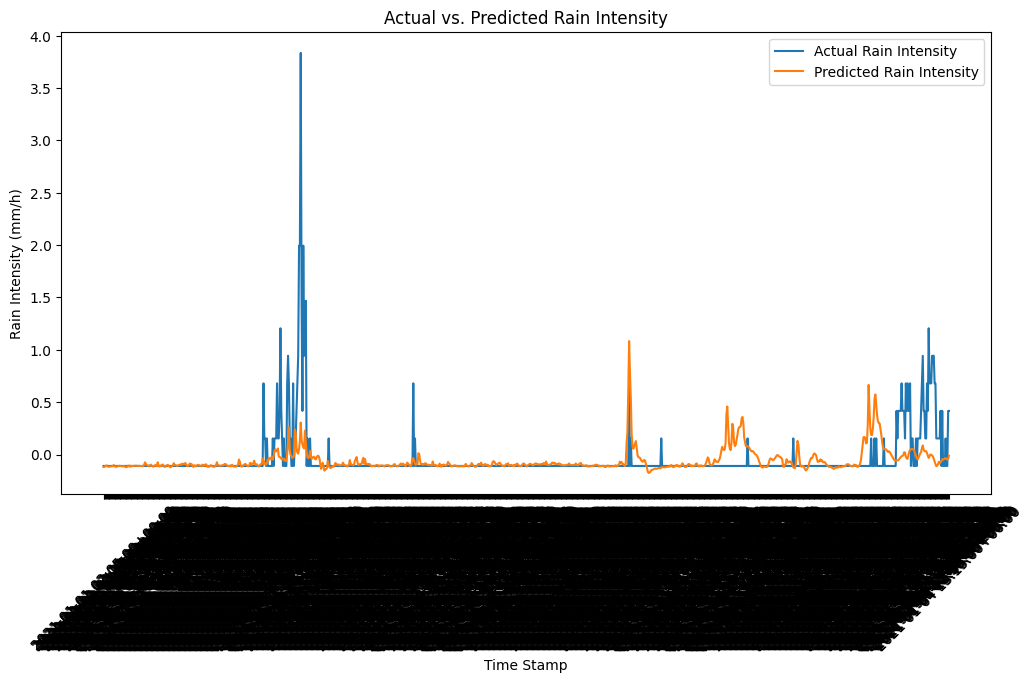

In [39]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data['timestamp_utc'].iloc[history_length:][:1000], test_y[:1000], label='Actual Rain Intensity')
plt.plot(test_data['timestamp_utc'].iloc[history_length:][:1000], predictions[:1000], label='Predicted Rain Intensity')
plt.xlabel('Time Stamp')
plt.ylabel('Rain Intensity (mm/h)')
plt.title('Actual vs. Predicted Rain Intensity')
plt.legend()
plt.xticks(rotation=45)

# Enable interactive mode and show the plot
plt.ion()
plt.show(block=False)
plt.pause(0.001)